In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import datasets, layers, models

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import os
import logging
import warnings

logging.getLogger("tensorflow").setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

2025-07-09 20:08:43.594794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752091723.781622      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752091723.835611      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [3]:
# -------------------------------------------------------------------
# 1) Configurações gerais (hiperparâmetros, caminhos, etc)
# -------------------------------------------------------------------

EPOCHS       = 30
BATCH_SIZE   = 128
VALID_SPLIT  = 0.1
MODEL_PATH   = "best_cifar10_model.h5"
TFLITE_PATH  = "cifar10_simple.tflite"
PATIENCE_ES  = 10
MONITOR_MET  = "val_loss"


# -------------------------------------------------------------------
# 2) Helpers
# -------------------------------------------------------------------
def get_callbacks():
    return [
        EarlyStopping(monitor=MONITOR_MET, patience=PATIENCE_ES, verbose=0, restore_best_weights=True),
        ModelCheckpoint(MODEL_PATH,   monitor=MONITOR_MET, save_best_only=True, verbose=0)
    ]

def plot_history(history):
    plt.figure(figsize=(12,4))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history[MONITOR_MET], label="val")
    plt.title("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.title("Accuracy")
    plt.legend()

    plt.show()

def evaluate_model(model, x_test, y_test):
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"Acurácia final no test set: {acc:.4f}")
    return loss, acc

def export_tflite(model, filename=TFLITE_PATH):
    print(f"Convertendo modelo para TFLite em `{filename}`...")
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(filename, "wb") as f:
        f.write(tflite_model)
    print("✅ Export concluído.")
    #return tflite_model






In [ ]:



def create_balanced_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(32, 32, 3)),

        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'), # Conv2D
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'), # Conv2D
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'), # Conv2D
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'), # Conv2D
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model




In [5]:
# 3. Orquestração do pipeline CIFAR-10 em uma única célula

print("🔨 Criando e compilando modelo para CIFAR-10")
model = create_balanced_model()
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()



🔨 Criando e compilando modelo para CIFAR-10


I0000 00:00:1752091763.562862      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141,994 (554.66 KB)

 Trainable params: 141,354 (552.16 KB)

 Non-trainable params: 640 (2.50 KB)


🚂 Iniciando treino por 30 epochs (batch size=128)
Epoch 1/30


I0000 00:00:1752091782.755479      95 service.cc:148] XLA service 0x7edafc0375b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752091782.756151      95 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752091783.371794      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


 21/352 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2105 - loss: 2.1024

I0000 00:00:1752091788.140576      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.4117 - loss: 1.6116 - val_accuracy: 0.1188 - val_loss: 3.8755
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6190 - loss: 1.0794 - val_accuracy: 0.5872 - val_loss: 1.1389
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6709 - loss: 0.9345 - val_accuracy: 0.6356 - val_loss: 1.0769
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7056 - loss: 0.8351 - val_accuracy: 0.7128 - val_loss: 0.8291
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7345 - loss: 0.7594 - val_accuracy: 0.7100 - val_loss: 0.8497
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7499 - loss: 0.7073 - val_accuracy: 0.7598 - val_loss: 0.6972
Epoch 7/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7700 - loss: 0.6633 - val_accuracy: 0.7708 - val_loss: 0.6718
Epoch 8/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7864 - loss: 0.6201 - val_accuracy: 0.7540 - va

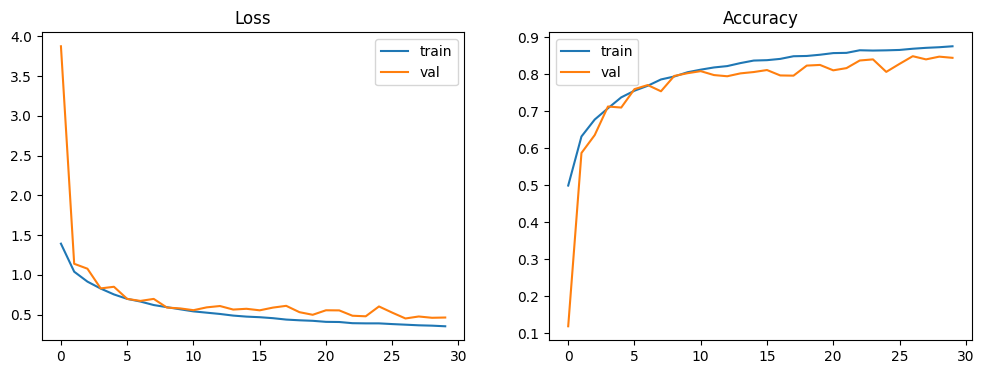


🔍 Avaliando no conjunto de teste
Acurácia final no test set: 0.8428

🛠 Exportando modelo para TFLite
Convertendo modelo para TFLite em `cifar10_simple.tflite`...
Saved artifact at '/tmp/tmp2wmsyddc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139483364561296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139483364561680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139483364563216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139483364562640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139483364563600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139483364561488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139483364562256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139483364562832: TensorSpec(shape=(), dtype=tf.resource, name=

W0000 00:00:1752091887.822455      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1752091887.822495      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1752091887.838445      35 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


In [6]:
print(f"\n🚂 Iniciando treino por {EPOCHS} epochs (batch size={BATCH_SIZE})")
history = model.fit(
    x_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALID_SPLIT,
    callbacks=get_callbacks(),
    verbose=1
)

print("\n📊 Plotando curva de treino")
plot_history(history)

print("\n🔍 Avaliando no conjunto de teste")
evaluate_model(model, x_test, y_test)

print("\n🛠 Exportando modelo para TFLite")
export_tflite(model, TFLITE_PATH)



📊 Plotando curva de treino


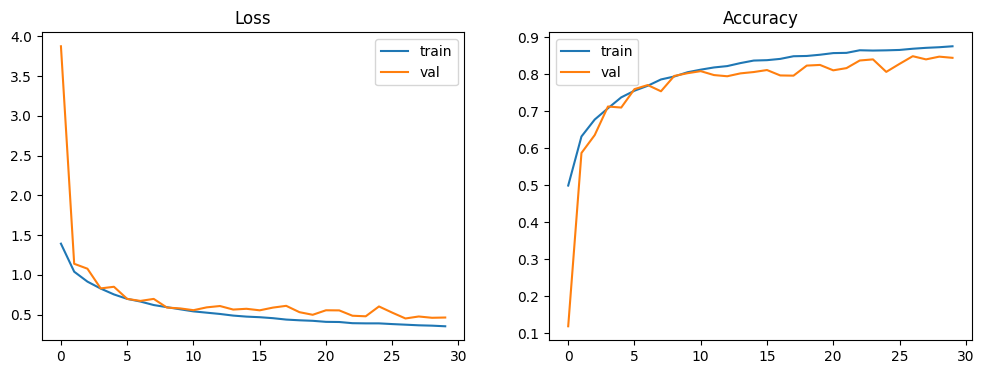


🔍 Avaliando no conjunto de teste
Acurácia final no test set: 0.8428


(0.46825844049453735, 0.8428000211715698)

In [7]:
print("\n📊 Plotando curva de treino")
plot_history(history)

print("\n🔍 Avaliando no conjunto de teste")
evaluate_model(model, x_test, y_test)

# Quantizar modelo para int8

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

CLASS_NAMES = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]
QUANTIZED_MODEL_FILENAME = "cifar10_simple_int8.tflite"

def convert_to_tflite_quantized(keras_model, representative_data, filename):
    print("Converting to TFLite with full integer quantization...")

    def representative_dataset_gen():
        for i in range(len(representative_data)):
            yield [representative_data[i:i+1]]

    converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8

    tflite_quant_model = converter.convert()

    with open(filename, "wb") as f:
        f.write(tflite_quant_model)

    size_kb = os.path.getsize(filename) / 1024
    print(f"Quantized model saved to {filename} ({size_kb:.1f} KB)")
    return tflite_quant_model

def run_quantized_inference(tflite_model_content, float_image_sample):
    interpreter = tf.lite.Interpreter(model_content=tflite_model_content)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    scale, zero_point = input_details["quantization"]
    quantized_input = (float_image_sample / scale + zero_point).astype(input_details["dtype"])

    interpreter.set_tensor(input_details["index"], quantized_input)
    interpreter.invoke()

    quantized_output = interpreter.get_tensor(output_details["index"])
    out_scale, out_zero_point = output_details["quantization"]
    float_output = (quantized_output.astype(np.float32) - out_zero_point) * out_scale

    predicted_label = np.argmax(float_output)
    return predicted_label

def plot_prediction(image, true_name, pred_name):
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(f"True: {true_name}\nPredicted: {pred_name}")
    plt.axis('off')
    plt.show()



Converting to TFLite with full integer quantization...
Saved artifact at '/tmp/tmpxjy0pzy_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139479247078800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139479247080528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139479247078992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139479247081104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139479247078608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139479247080336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139479247081488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139479247082832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139479247082256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139479247083408: TensorSpec(sha

W0000 00:00:1752092002.199897      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1752092002.199931      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


Quantized model saved to cifar10_simple_int8.tflite (155.0 KB)

Verifying inference with the INT8 model...
True Class:      0 (airplane)
Predicted Class: 0 (airplane)


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


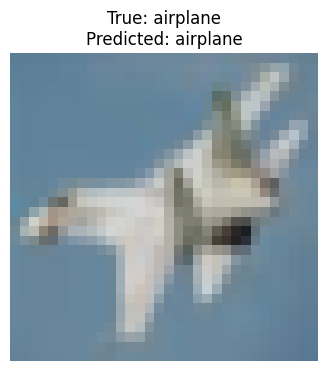

In [10]:
model = tf.keras.models.load_model('/kaggle/working/best_cifar10_model.h5')

(x_train, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0

representative_data = x_train[:200]
tflite_model_content = convert_to_tflite_quantized(
    keras_model=model,
    representative_data=representative_data,
    filename=QUANTIZED_MODEL_FILENAME
)

print("\nVerifying inference with the INT8 model...")
test_index      = 10
image_sample    = x_test[test_index:test_index+1]
true_label      = int(y_test[test_index][0])
true_name       = CLASS_NAMES[true_label]
predicted_label = run_quantized_inference(tflite_model_content, image_sample)
pred_name       = CLASS_NAMES[predicted_label]

print(f"True Class:      {true_label} ({true_name})")
print(f"Predicted Class: {predicted_label} ({pred_name})")
plot_prediction(image_sample[0], true_name, pred_name)


In [11]:
def evaluate_tflite_model(model_path, x_test, y_test):
    if not os.path.exists(model_path):
        print(f"Erro: Arquivo do modelo não encontrado em '{model_path}'")
        return None

    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    input_scale, input_zero_point = input_details["quantization"]
    output_scale, output_zero_point = output_details["quantization"]
    input_dtype = input_details["dtype"]

    correct_predictions = 0
    total_images = len(x_test)

    for i in range(total_images):
        image = x_test[i]
        true_label = y_test[i][0]

        quantized_input = (image / input_scale) + input_zero_point
        quantized_input = np.expand_dims(quantized_input, axis=0).astype(input_dtype)

        interpreter.set_tensor(input_details['index'], quantized_input)
        interpreter.invoke()

        quantized_output = interpreter.get_tensor(output_details['index'])[0]
        dequantized_output = (quantized_output.astype(np.float32) - output_zero_point) * output_scale

        predicted_label = np.argmax(dequantized_output)

        if predicted_label == true_label:
            correct_predictions += 1

    accuracy = correct_predictions / total_images
    return accuracy

TFLITE_MODEL_PATH = 'cifar10_simple_int8.tflite'

(_, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_test = x_test.astype("float32") / 255.0

final_accuracy = evaluate_tflite_model(
    model_path=TFLITE_MODEL_PATH,
    x_test=x_test,
    y_test=y_test
)

if final_accuracy is not None:
    print(f"Modelo: {TFLITE_MODEL_PATH}")
    print(f"Imagens de teste: {len(x_test)}")
    print(f"Acurácia final no dataset de teste: {final_accuracy:.4f}")

Modelo: cifar10_simple_int8.tflite
Imagens de teste: 10000
Acurácia final no dataset de teste: 0.7755


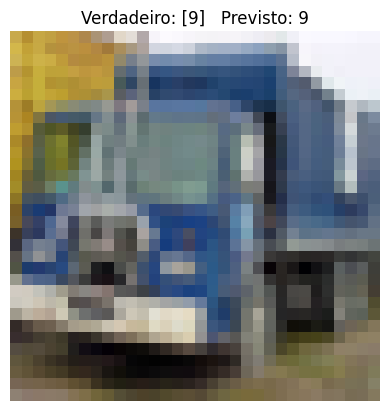

Confiança: 0.988


In [29]:
import random
import numpy as np
import matplotlib.pyplot as plt

# (Re)carrega o interpreter e detalhes—evita NameError
interpreter = tf.lite.Interpreter(model_path="cifar10_simple_int8.tflite")
interpreter.allocate_tensors()
input_details  = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

# extrai escala e zero-point
in_scale, in_zp   = input_details["quantization"]
out_scale, out_zp = output_details["quantization"]

# escolhe amostra aleatória
idx  = 14#random.randint(0, x_test.shape[0] - 1)
img  = x_test[idx]
true = y_test[idx]

# quantiza entrada
img_q = (img / in_scale + in_zp).astype(input_details["dtype"])[None, ...]

# prepara e invoca
interpreter.resize_tensor_input(input_details["index"], img_q.shape)
interpreter.allocate_tensors()
interpreter.set_tensor(input_details["index"], img_q)
interpreter.invoke()

# obtém saída e dequantiza
pred_q  = interpreter.get_tensor(output_details["index"])[0]
pred_f  = (pred_q.astype(np.float32) - out_zp) * out_scale
label   = pred_f.argmax()

# plota
plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"Verdadeiro: {true}   Previsto: {label}")
plt.axis("off")
plt.show()

# confiança
print(f"Confiança: {pred_f[label]:.3f}")
